In [3]:
%load_ext tensorboard

%run setup/GpuOptions.ipynb

import os
import sys
import logging

'..' not in sys.path and sys.path.append('..')
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import importlib
import tensorflow as tf
from datetime import datetime
from common import frozenmodel
from common.dataset import Dataset
from tensorflow.keras import callbacks, optimizers, losses
importlib.reload(frozenmodel)

dataset = Dataset(
    '../dataset/dataset-2022-10-19T22-51-08',
    batch_size=10,
    image_size=(1080, 1920))

model = frozenmodel.generate_model(
    weights_filepath='isthemountainout.best.h5',
    with_augmentations=True,
    can_ignore_weights=True)
model.compile(
    optimizer=optimizers.Adadelta(
        learning_rate=optimizers.schedules.CosineDecayRestarts(
            2.5,
            # Decay over 5 epochs and then restart 
            dataset.training.cardinality().numpy() * 10)),
    loss=losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.08),
    metrics=['accuracy'],
)
model.fit(
    dataset.training,
    epochs=700,
    verbose=True,
    validation_data=dataset.validation,
    callbacks=[
        callbacks.TensorBoard(
            log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")),
        tf.keras.callbacks.ModelCheckpoint(
            'isthemountainout.best.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=True),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=100,
            restore_best_weights=True,
            verbose=True),
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join('tensor-logs', 'fit', datetime.now().strftime('%Y%m%d%H%M%S')),
            update_freq=50,
            write_images=True,
            write_graph=True,
            embeddings_freq=10),
    ])

Epoch 1/700
249/249 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.8419
Epoch 1: val_loss improved from inf to 1.45755, saving model to isthemountainout.best.h5
249/249 [==============================] - 113s 417ms/step - loss: 0.6193 - accuracy: 0.8419 - val_loss: 1.4576 - val_accuracy: 0.5089
Epoch 2/700
249/249 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.8358
Epoch 2: val_loss improved from 1.45755 to 0.55486, saving model to isthemountainout.best.h5
249/249 [==============================] - 101s 404ms/step - loss: 0.6249 - accuracy: 0.8358 - val_loss: 0.5549 - val_accuracy: 0.8808
Epoch 3/700
249/249 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.8314
Epoch 3: val_loss did not improve from 0.55486
249/249 [==============================] - 101s 402ms/step - loss: 0.6195 - accuracy: 0.8314 - val_loss: 1.0924 - val_accuracy: 0.5314
Epoch 4/700
249/249 [==============================] - ETA: 0s - loss: 0.61

ResourceExhaustedError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Taylor\AppData\Local\Temp\ipykernel_24196\2578742606.py", line 23, in <module>
      model.fit(
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Taylor\AppData\Local\Temp\ipykernel_24196\2578742606.py", line 23, in <module>
      model.fit(
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Taylor\anaconda3\envs\mountain\lib\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[model/random_brightness/loop_body/stateful_uniform/Bitcast/pfor/while/body/_378/model/random_brightness/loop_body/stateful_uniform/Bitcast/pfor/while/TensorArrayV2Write/TensorListSetItem/_244]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_16536]

GPU Available: True
Enabling memory growth on PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
loading model with best weights
Found 3106 files belonging to 4 classes.
Using 2175 files for training.
Found 3106 files belonging to 4 classes.
Using 931 files for validation.


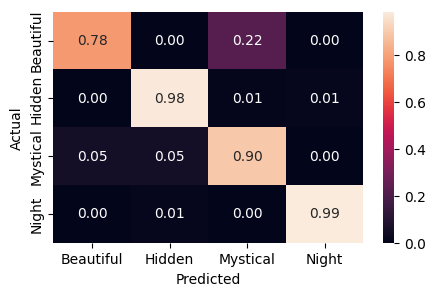

In [6]:
%run setup/GpuOptions.ipynb

import os
import sys
import logging

'..' not in sys.path and sys.path.append('..')
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import importlib
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from common import frozenmodel
from common.dataset import Dataset
importlib.reload(frozenmodel)

print('loading model with best weights')
# from common.weights import weights
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../isthemountainout-credentials.json'
# with weights() as filename:
model = frozenmodel.generate_model(
    weights_filepath='isthemountainout.h5', # filename
    with_augmentations=True)

dataset = Dataset(
    '../dataset/dataset-2022-10-19T22-51-08',
    batch_size=6,
    image_size=(1080, 1920),
    validation_split=0.3)
validations = dataset.validation
predictions = []
labels = []
for data, label in validations:
  labels.append(tf.argmax(label, axis=1))
  predictions.append(tf.math.argmax(tf.nn.softmax(model.predict(data, verbose=0)), axis=1))
labels = tf.concat(labels, axis=0)
predictions = tf.concat(predictions, axis=0)
cm = confusion_matrix(labels, predictions, labels=list(range(len(dataset.validation.class_names))))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(
  cmn,
  annot=True,
  fmt='.2f',
  xticklabels=dataset.validation.class_names,
  yticklabels=dataset.validation.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)